In [12]:
import os
import re
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from itertools import cycle

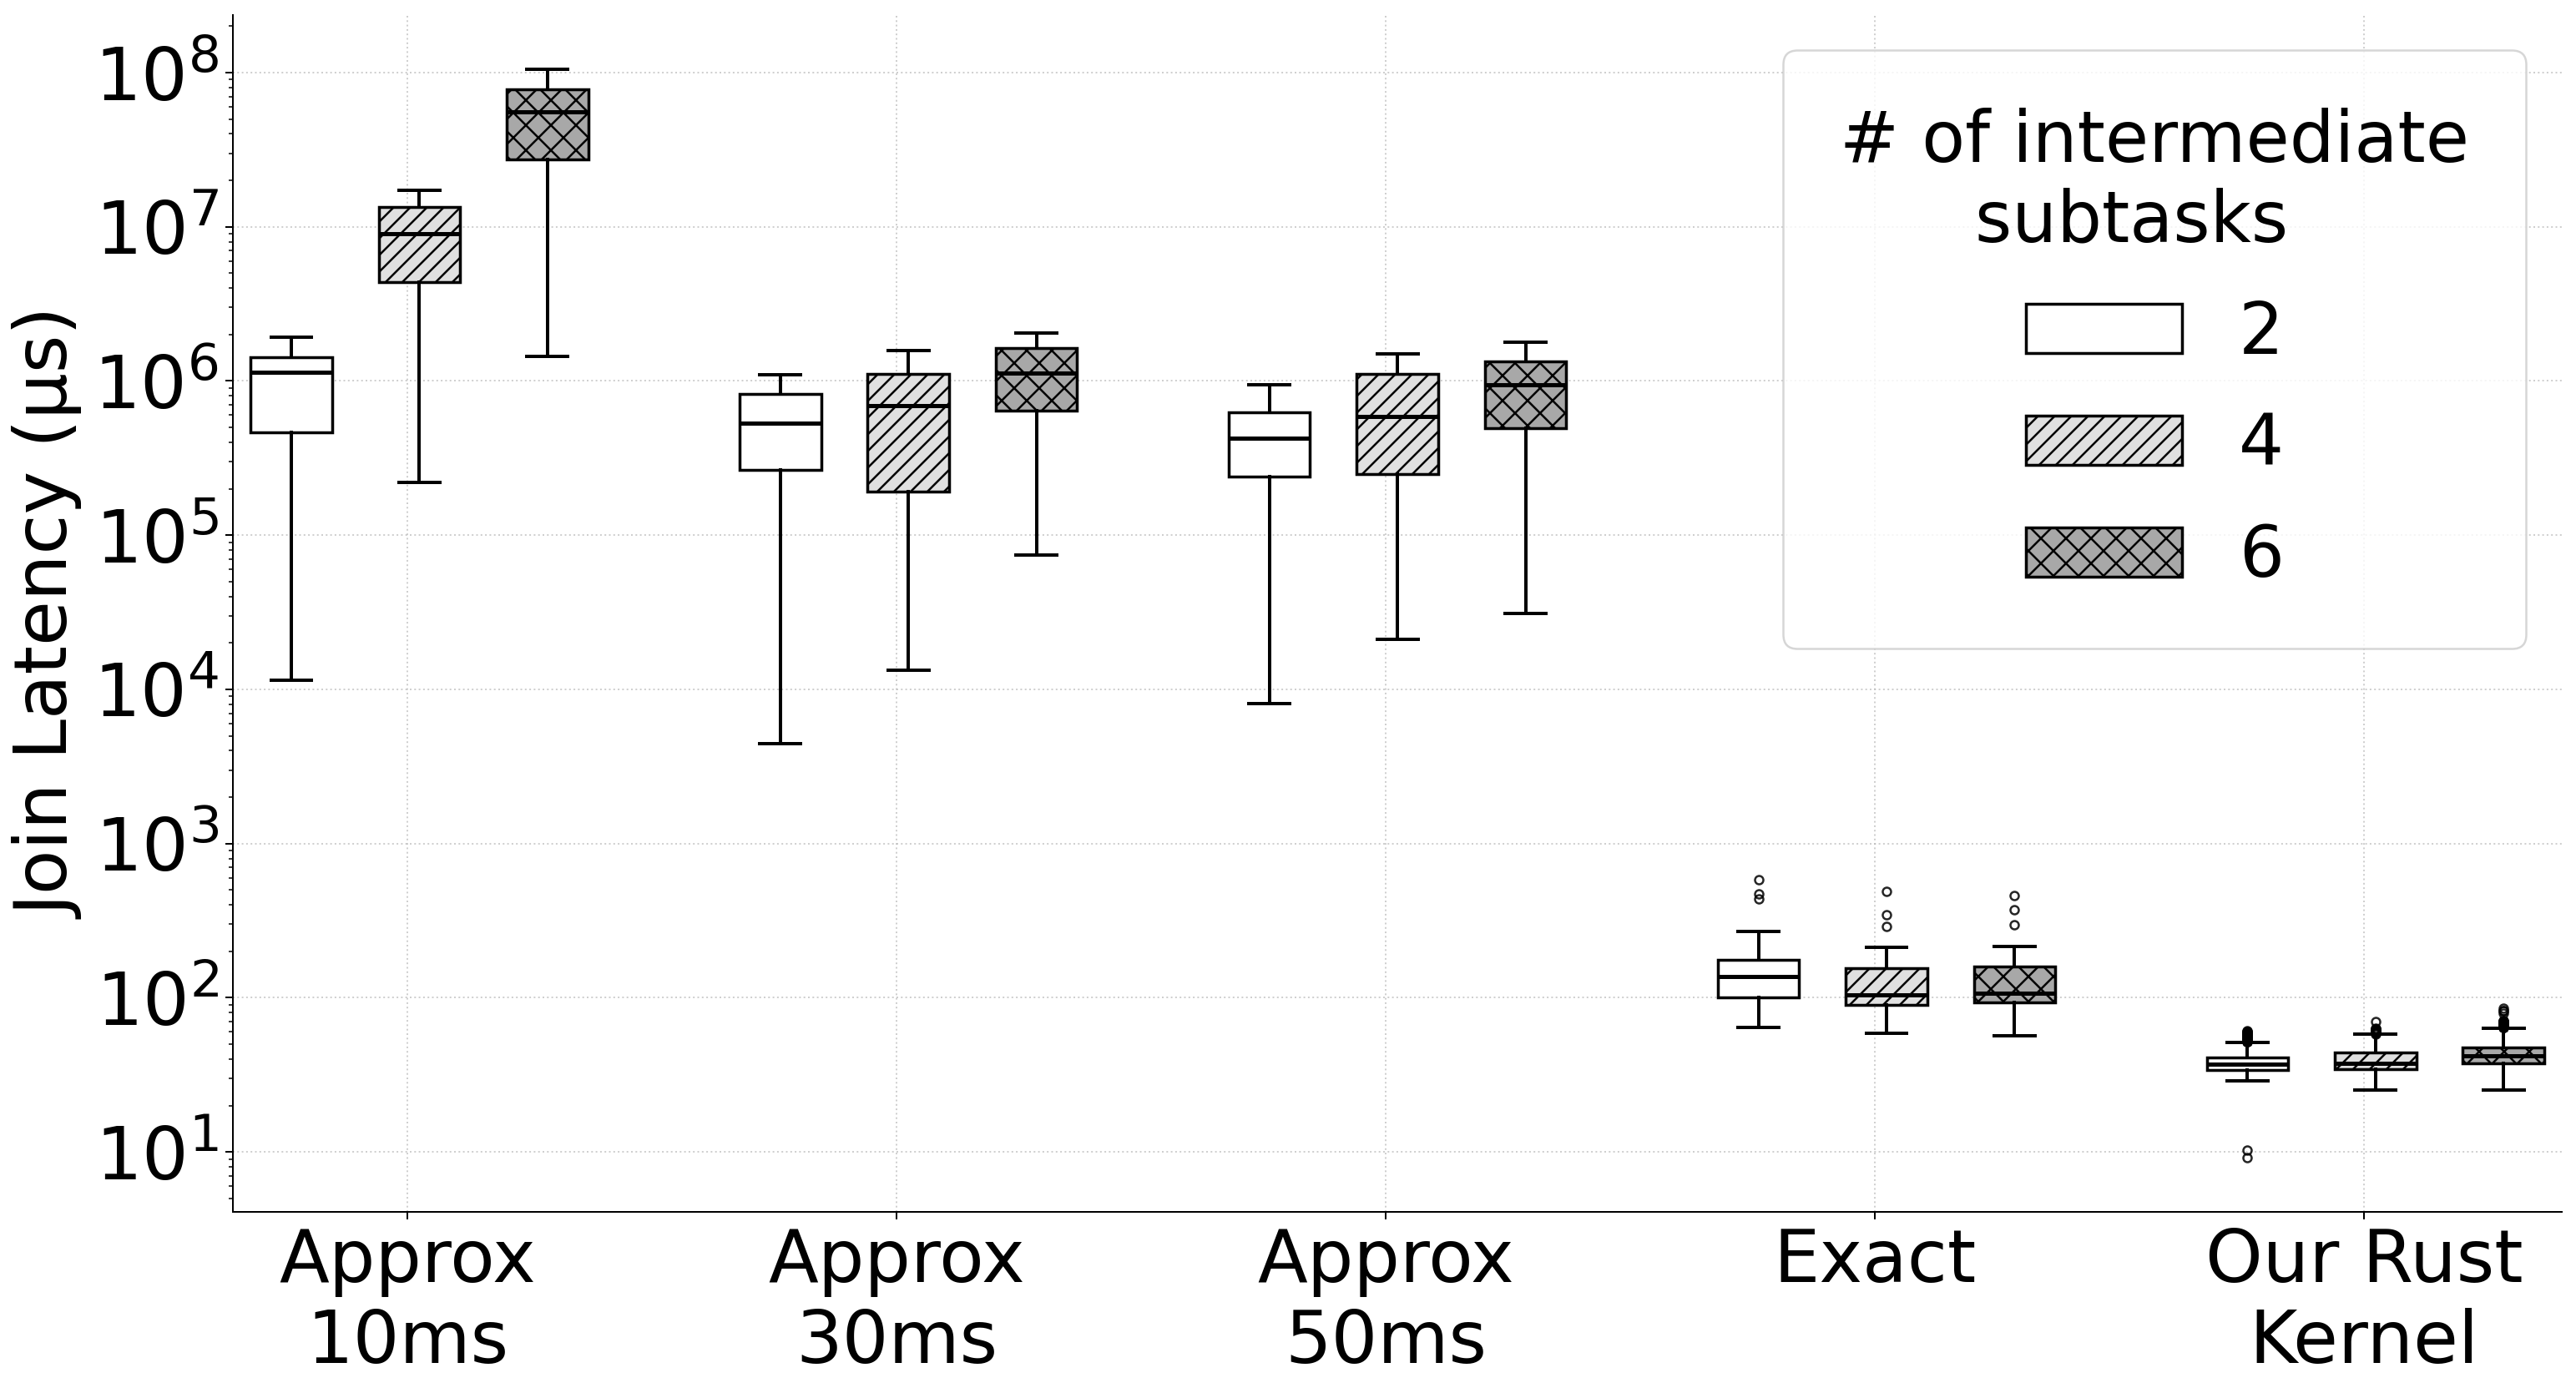

Saved: /Users/sykwer/work/rtas25bp/eval.pdf
Saved: /Users/sykwer/work/rtas25bp/eval.png


In [47]:
# -----------------------------
# 1) Load data
# -----------------------------
PUBLISHERS = [2, 4, 6]  # order inside each category

our_kernel_name = "Our Rust\nKernel"

CATEGORY_FILES = {
    "Approx\n10ms": "approximate10_latencies_us.txt",
    "Approx\n30ms": "approximate30_latencies_us.txt",
    "Approx\n50ms": "approximate50_latencies_us.txt",
    "Exact":       "exact50_latencies_us.txt",
    # Awkernel file name depends on publisher count
    our_kernel_name:    lambda pub: f"latency_log_ice_{pub}.txt",
}

def read_values(path):
    vals = []
    try:
        with open(path, "r") as f:
            for line in f:
                s = line.strip()
                if not s:
                    continue
                try:
                    vals.append(float(s))
                except ValueError:
                    pass  # skip malformed
    except FileNotFoundError:
        return []
    return vals

# data[category][pub] = list-of-floats (µs)
data = {cat: {} for cat in CATEGORY_FILES.keys()}

for pub in PUBLISHERS:
    pub_dir = os.path.join(BASE_DIR, str(pub))
    for cat, spec in CATEGORY_FILES.items():
        fname = spec(pub) if callable(spec) else spec
        path = os.path.join(pub_dir, fname)
        vals = read_values(path)
        # Scale Awkernel by 1e3 to align to µs
        if cat == our_kernel_name and vals:
            vals = [v / 1e3 for v in vals]
        data[cat][pub] = vals

# -----------------------------
# 2) Plot settings (monochrome, large fonts)
# -----------------------------
plt.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,

    # 大きめフォント設定
    "font.size": 35,            # base
    "axes.titlesize": 35,
    "axes.labelsize": 35,
    "xtick.labelsize": 35,
    "ytick.labelsize": 35,
    "legend.fontsize": 35,
})

categories = list(CATEGORY_FILES.keys())
n_cat = len(categories)
n_pub = len(PUBLISHERS)

# Monochrome palette (light -> dark) + hatch for B/W print
FACE_COLORS = ["white", "#E0E0E0", "#A8A8A8"]
HATCHES     = ["", "///", "xx"]
EDGE_COLOR  = "black"

# Spacing tuned for wide 16:9 and large fonts
group_gap = 1.2
box_w     = 0.70   # wider boxes so they don't collapse in narrow subplots
inner_gap = 0.10   # tighten intra-group spacing to make room


# Compute positions
positions = []
labels_at = []
for ci in range(n_cat):
    base = ci * (n_pub + group_gap)
    labels_at.append(base + (n_pub - 1) / 2.0)
    for pi in range(n_pub):
        positions.append(base + pi * (1.0 + inner_gap))

# Flatten data for boxplot; remember empties for annotation
plot_data = []
empty_positions = []
for ci, cat in enumerate(categories):
    for pi, pub in enumerate(PUBLISHERS):
        vals = data[cat][pub]
        plot_data.append(vals)
        if not vals:
            empty_positions.append(positions[len(plot_data) - 1])

# -----------------------------
# 3) Draw (16:9, wide)
# -----------------------------
fig, ax = plt.subplots(figsize=(18, 10.125))  # 16:9 の比率

bp = ax.boxplot(
    plot_data,
    positions=positions,
    widths=box_w,
    patch_artist=True,
    showfliers=True,
    medianprops=dict(linewidth=2.0, color="black"),
    whiskerprops=dict(color=EDGE_COLOR, linewidth=1.6),
    capprops=dict(color=EDGE_COLOR, linewidth=1.6),
)

# Style boxes (repeat per category)
for i, patch in enumerate(bp["boxes"]):
    pub_idx = i % n_pub
    patch.set_facecolor(FACE_COLORS[pub_idx])
    patch.set_edgecolor(EDGE_COLOR)
    patch.set_linewidth(1.4)
    patch.set_hatch(HATCHES[pub_idx])

# Outliers (fliers) style — keep them visible but unobtrusive
for fl in bp["fliers"]:
    fl.set_marker("o")
    fl.set_markersize(4.0)
    fl.set_alpha(0.85)
    fl.set_markeredgecolor(EDGE_COLOR)
    fl.set_markerfacecolor("none")

# Axes
ax.set_yscale("log")
ax.set_ylabel("Join Latency (µs)")  # Awkernel は 1e3 で割って µs に統一
ax.set_xticks(labels_at)
ax.set_xticklabels(categories)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Annotate EMPTY at geometric center of y-range
yl = ax.get_ylim()
y_center = np.sqrt(yl[0] * yl[1]) if yl[0] > 0 else (yl[0] + yl[1]) / 2.0
for xpos in empty_positions:
    ax.text(xpos, y_center, "EMPTY", rotation=90, ha="center", va="center", fontsize=16)

# Legend — title and entries per your naming
legend_title = "# of intermediate\n      subtasks"
legend_labels = [str(pub) for pub in PUBLISHERS]  # "2", "4", "6"
legend_handles = [
    Patch(facecolor=FACE_COLORS[i], edgecolor=EDGE_COLOR, linewidth=1.4, hatch=HATCHES[i], label=legend_labels[i])
    for i in range(n_pub)
]
leg = ax.legend(
    handles=legend_handles,
    title=legend_title,
    loc="upper right",
    frameon=True,
    fontsize=34,         # 大きめ
    title_fontsize=34,   # タイトルも大きめ
    borderpad=0.8,
    labelspacing=0.6,
    handlelength=2.2,
)

# ax.set_title("Latency Distribution by Category — Monochrome, log-scale (16:9)")

plt.tight_layout()

out_pdf = "eval.pdf"
out_png = "eval.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=240, bbox_inches="tight")
plt.show()

print(f"Saved: {os.path.abspath(out_pdf)}")
print(f"Saved: {os.path.abspath(out_png)}")